<a target="_blank" href="https://colab.research.google.com/github/jgomelop/ai4eng_CusFraDect/blob/master/3%20-%20Seleccion%20de%20Modelos.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown https://drive.google.com/uc?id=1QoGQzRwfyK8hdYKKnnZa5YGokbAD0Ksy

Downloading...
From: https://drive.google.com/uc?id=1QoGQzRwfyK8hdYKKnnZa5YGokbAD0Ksy
To: /content/data_clean.zip
100% 51.8M/51.8M [00:00<00:00, 57.3MB/s]


In [3]:
!unzip data_clean.zip

Archive:  data_clean.zip
  inflating: test_clean.csv          
  inflating: train_clean.csv         


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [5]:
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))
    

In [6]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
  """
  From https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook

  """
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df
  

In [7]:
train = pd.read_csv("train_clean.csv", index_col=0)
train = reduce_mem_usage(train)
train.head()

Mem. usage decreased to 223.92 Mb (82.0% reduction)


,TransactionID,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,R_emaildomain_suffix_com,R_emaildomain_suffix_de,R_emaildomain_suffix_es,R_emaildomain_suffix_fr,R_emaildomain_suffix_jp,R_emaildomain_suffix_mx,R_emaildomain_suffix_nan,R_emaildomain_suffix_uk,R_emaildomain_suffix_us,isFraud
366215,3353215.0,49.00000,17184.0,321.0,150.0,226.0,310.0,87.0,8.0,2.0,...,0,0,0,0,0,0,1,0,0,0
437716,3424716.0,20.53125,17152.0,273.0,185.0,197.0,299.0,87.0,8.0,2.0,...,1,0,0,0,0,0,0,0,0,0
578692,3565692.0,22.00000,16312.0,400.0,150.0,224.0,123.0,87.0,8.0,1.0,...,1,0,0,0,0,0,0,0,0,0
364816,3351816.0,86.00000,12600.0,111.0,150.0,166.0,494.0,87.0,4.0,1.0,...,0,0,0,0,0,0,1,0,0,0
223792,3210792.0,236.00000,7480.0,490.0,150.0,226.0,325.0,87.0,8.0,111.0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
X_train = train.drop("isFraud", axis = 1)
X_train = reduce_mem_usage(X_train)
y_train = train["isFraud"]

Mem. usage decreased to 223.53 Mb (0.0% reduction)


In [9]:
test = pd.read_csv("test_clean.csv", index_col=0)
test = reduce_mem_usage(test)
test.head()

Mem. usage decreased to 95.63 Mb (82.1% reduction)


,TransactionID,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,R_emaildomain_suffix_com,R_emaildomain_suffix_de,R_emaildomain_suffix_es,R_emaildomain_suffix_fr,R_emaildomain_suffix_jp,R_emaildomain_suffix_mx,R_emaildomain_suffix_nan,R_emaildomain_suffix_uk,R_emaildomain_suffix_us,isFraud
470624,3457624.0,724.0000,7824.0,481.0,150.0,224.0,387.0,87.0,8.0,3.0,...,0,0,0,0,0,0,1,0,0,0
565820,3552820.0,108.5000,12544.0,321.0,150.0,226.0,476.0,87.0,0.0,2.0,...,0,0,0,0,0,0,1,0,0,0
284083,3271083.0,47.9375,9400.0,111.0,150.0,224.0,315.0,87.0,6.0,1.0,...,0,0,0,0,0,0,1,0,0,0
239689,3226689.0,100.6250,15888.0,545.0,185.0,138.0,299.0,87.0,8.0,2.0,...,1,0,0,0,0,0,0,0,0,0
281855,3268855.0,107.9375,15496.0,490.0,150.0,226.0,299.0,87.0,8.0,10.0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
X_test = test.drop("isFraud", axis = 1)
X_test = reduce_mem_usage(X_test)
y_test = test["isFraud"]

Mem. usage decreased to 95.46 Mb (0.0% reduction)


# Entrenamiento de clasificadores

In [11]:
from sklearn.model_selection import cross_validate, ShuffleSplit

In [12]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=5)
gnb = GaussianNB()

In [13]:
test_size = 0.3 # En el preprocesado de datos se decidió así
val_size  = test_size/(1-test_size) 

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

In [15]:
X_train_norm = scaler_train.fit_transform(X_train)
X_test_norm = scaler_test.fit_transform(X_test)

In [16]:
zscores = []
estimators = [lr, dt, gnb]
for estimator in estimators:
    print("--")
    z = cross_validate(estimator, X_train, y_train, return_train_score=True, 
                       return_estimator=False,
                       scoring="roc_auc", 
                       cv=ShuffleSplit(n_splits=5, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(z["test_score"]))
best = np.argmax(zscores)
print ("selecting ", best)
best_estimator = estimators[best]
print ("\nselected model")
print (best_estimator)

--


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

test score   0.635 (±0.0164) with 5 splits
train score  0.633 (±0.0151) with 5 splits
--
test score   0.775 (±0.0044) with 5 splits
train score  0.781 (±0.0065) with 5 splits
--
test score   0.715 (±0.0083) with 5 splits
train score  0.712 (±0.0050) with 5 splits
selecting  1

selected model
DecisionTreeClassifier(max_depth=5)


Observamos que la regresión logistica como está no está convergiendo: Nos queda el DecisionTreeClassifier y el GaussianNB(), donde el primero sea probablemente mejor.

In [17]:
from sklearn.metrics import roc_auc_score


In [18]:

best_estimator.fit(X_train, y_train)

y_score = best_estimator.predict_proba(X_test)[:, 1]
reported_performance = roc_auc_score(y_true = y_test, y_score = y_score)
print ("reported performance of selectd model %.3f"%reported_performance)

reported performance of selectd model 0.779


In [19]:
from sklearn.metrics import RocCurveDisplay

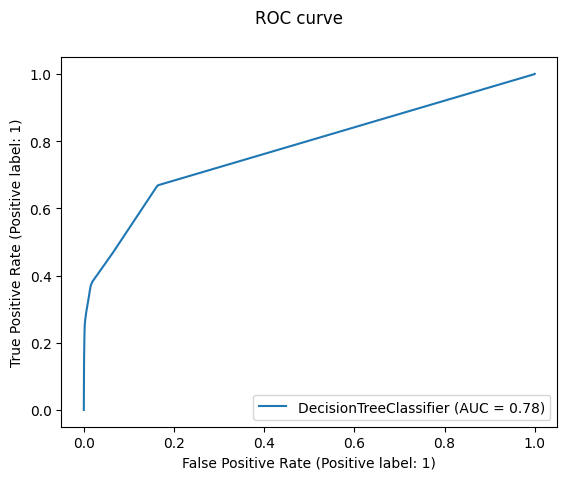

In [20]:
dt_disp = RocCurveDisplay.from_estimator(best_estimator, X_test, y_test)
dt_disp.figure_.suptitle("ROC curve ")
plt.show()

In [21]:
from sklearn.model_selection import LearningCurveDisplay

In [22]:
from sklearn.model_selection import learning_curve


In [23]:
train_sizes, train_scores, valid_scores = learning_curve(best_estimator, X_train, y_train, 
                                                         train_sizes= [0.3, 0.5,0.7,0.9], 
                                                        scoring ='roc_auc', 
                                                         cv = ShuffleSplit(n_splits=10, test_size=val_size))

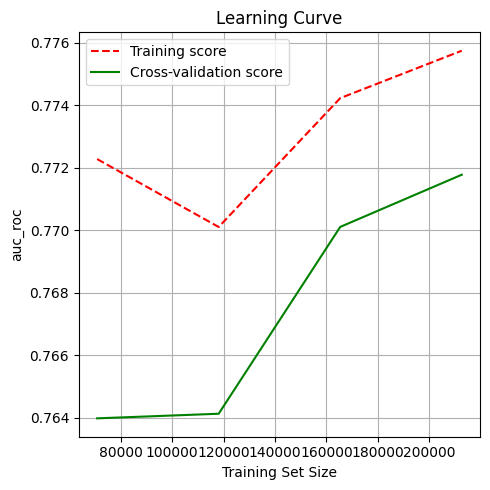

In [24]:
train_scores = np.abs(train_scores)
valid_scores = np.abs(valid_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



plt.grid()
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("auc_roc"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Búsqueda de hiperparámetros

In [31]:
from sklearn.model_selection import GridSearchCV

#Esta celda puede tomar un tiempo considerable en su ejecución
parametros = {'max_depth': [1,5,10,100,25]}
#dt = DecisionTreeClassifier()


decission_tree = GridSearchCV(estimator = best_estimator,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'roc_auc',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeClassifier(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 100, 25]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [32]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeClassifier(max_depth=10)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 10}


In [34]:
Des_tree = DecisionTreeClassifier(max_depth=10)
Des_tree.fit(X_train, y_train)

Des_tree.predict_proba(X_test)[:, 1]
print('ROC_AUC del Decision Tree en entrenamiento: ',"{:.5f}".format(roc_auc_score((y_train) , (Des_tree.predict_proba(X_train)[:, 1]))))
print('ROC_AUC del Decision Tree seleccionado: ',"{:.5f}".format(roc_auc_score(y_test , Des_tree.predict_proba(X_test)[:, 1])))

ROC_AUC del Decision Tree en entrenamiento:  0.85603
ROC_AUC del Decision Tree seleccionado:  0.84424


Observamos una mejoría en el performance del modelo.